# 데이터셋 다운로드

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'oreocube' # username
os.environ['KAGGLE_KEY'] = '6eccd7011bed88a9e3cdc213d8761acb' # key

In [ ]:
!kaggle datasets download -d moltean/fruits
!unzip -q fruits.zip

 99% 1.21G/1.22G [00:32<00:00, 54.9MB/s]
100% 1.22G/1.22G [00:32<00:00, 39.9MB/s]


# 패키지 임포트

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 증강 기법 사용해서 전처리하기

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1, # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1, # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)
test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory( # 이미지 데이터를 폴더에서 읽어옴
  'fruits-360_dataset/fruits-360/Training',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)
test_gen = test_datagen.flow_from_directory(
  'fruits-360_dataset/fruits-360/Test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# 데이터 확인하기
클래스 확인

In [ ]:
from pprint import pprint
pprint(train_gen.class_indices)

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Corn': 35,
 'Corn Husk': 36,
 'Cucumber Ripe': 37,
 'Cucumber Ripe 2': 38,
 'Dates': 39,
 'Eggplant': 40,
 'Fig': 41,
 'Ginger Root': 42,
 'Granadilla': 43,
 'Grape Blue': 44,
 'Grape Pink': 45,
 'Grape White': 46,
 'Grape White 2': 47,
 'Grape White 3': 48,
 'Grap

샘플 이미지 보기

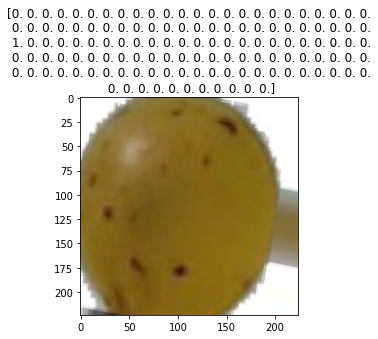

In [ ]:
preview_batch = train_gen.__getitem__(0) # 0번 배치의 이미지를 가져와라

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0])) # 0번 이미지의 라벨
plt.imshow(preview_imgs[0])  # 0번 이미지

# 전이학습 - Inception v3 모델 가져와서 수정하기

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input = Input(shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(131, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

# 학습
모델을 저장했다가 나중에 다시 쓸 수 있도록 콜백 정의

모델의 weight와 네트워크 구조를 저장한다.


ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)

val_acc가 높은 1개의 모델(save_best_only)을 model.h5라는 파일로 저장한다. 

https://keras.io/api/callbacks/model_checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
  train_gen,
  validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
  epochs=20, # epochs 복수형으로 쓰기!
  callbacks=[
    ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
  ]
)

Epoch 1/20
2116/2116 [==============================] - 1418s 651ms/step - loss: 1.3629 - acc: 0.6299 - val_loss: 0.4365 - val_acc: 0.8670

Epoch 00001: val_acc improved from -inf to 0.86702, saving model to model.h5
Epoch 2/20
2116/2116 [==============================] - 1368s 646ms/step - loss: 0.2047 - acc: 0.9338 - val_loss: 0.5070 - val_acc: 0.8668

Epoch 00002: val_acc did not improve from 0.86702
Epoch 3/20
2116/2116 [==============================] - 1366s 646ms/step - loss: 0.1498 - acc: 0.9524 - val_loss: 2.6882 - val_acc: 0.8458

Epoch 00003: val_acc did not improve from 0.86702
Epoch 4/20
2116/2116 [==============================] - 1367s 646ms/step - loss: 0.0949 - acc: 0.9709 - val_loss: 0.2645 - val_acc: 0.9301

Epoch 00004: val_acc improved from 0.86702 to 0.93005, saving model to model.h5
Epoch 5/20
2116/2116 [==============================] - 1363s 644ms/step - loss: 0.0906 - acc: 0.9725 - val_loss: 0.0926 - val_acc: 0.9734

Epoch 00005: val_acc improved from 0.93005 

# 학습 결과 그래프

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
  axes[0].plot(history.history['loss'])
  axes[0].plot(history.history['val_loss']
  axes[1].plot(history.history['acc'])
  axes[1].plot(history.history['val_acc'])
)

# 학습된 모델 로딩하기

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# 테스트

In [ ]:
# 배치 인덱스 바꿔가면서 테스트 할 수 있다
test_imgs, test_labels = test_gen.__getitem__(100) 

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)